# Animal Classification
This task has been described as follows,

>Write a Jupyter notebook to classify 10 different classes of animal of your choice.
Use Duck Duck Go to scrape sample images off the Web based on the fast.ai course
example on birds. Design an appropriate multiclass loss function or describe which
one was used. Analyse your data and results using tools such as t-SNE and
Confusion matrices. Report on metrics such as classification accuracy and explain
the methods used.

Following this description, a script investigating the use of a neural network to classify 10 different animals based on images collected from duckduckgo search has been implemented. These results are then discussed and visualised using a variety of classicial approaches.

This work is heavily based upon the fast.ai course, Practical Deep Learning for Coders, v3, and the associated book, Deep Learning for Coders with fastai and PyTorch: AI Applications Without a PhD. See this link for more information: https://course.fast.ai/. It also draws reference from a variety of online resources, referenced where needed.

# Step 0: Setup
We begin by checking network connection, installing non-standard libraries, and importing the required libraries.

In [1]:
# Check for an ineternet connection...
import socket,warnings
try:
  socket.setdefaulttimeout(1)
  socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

# Patch for ipython to allow for updating of display (https://stackoverflow.com/questions/75936184/learn-fine-tune-not-showing-progress-bar-for-each-epoch)
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [2]:
# Update fastai 

%pip install -Uqq duckduckgo_search
%pip install -Uqq fastcore
%pip install -Uqq fastdownload
%pip install -Uqq fastai
%pip install -Uqq seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
from __future__ import annotations
import shutil
import itertools
import time
import random
import os
from pathlib import Path

import numpy as np
from duckduckgo_search import DDGS
import fastcore.all as fca
import fastai.vision.all as fva

from sklearn import manifold
import seaborn as sns
from matplotlib import pyplot as plt


# Step 1: Download images of chosen animals
With the required libraries imported, we can now begin to download images of the chosen animals. For this we will be attempting to classify the following animals:

1. Ibis
2. BushTurkey
3. Kangaroo
4. Emu
5. Crocodile
6. Koala
7. Platypus
8. Echidna
9. Cockatoo
10. Wombat

To make the retrieval of images using DDGS easier, we define some helper functions to retrieve datasets and store them locally.

In [4]:
def search_images(term: str, max_images: int = 200, **kwargs) -> fca.L:
  """Generate a list of image URLs from DuckDuckGo

  Args:
      term (str): Search term
      max_images (int, optional): Upper limit on the number of URLs to retrieve. Defaults to 200.

  Returns:
      fca.L: List of image URLs
  """
  ddgs = DDGS()

  ddgs_images_gen = ddgs.images(
      term,
      region="wt-wt",
      safesearch="Off",
      **kwargs
  )
  return fca.L(itertools.islice(ddgs_images_gen, max_images)).itemgot('image')

def download_images(
    term: str, path_string: str, clear_directory: bool = True,
    max_images: int = 200, max_image_size: int | None = None,
    workers: int = 8) -> list[str]:
  """Download images from DuckDuckGo

  Args:
      term (str): Search query.
      path_string (str): Save path.
      max_images (int, optional): Maximum number of images to download. Defaults to 200.
      max_image_size (int | None, optional): Maximum image size. Defaults to None.
      workers (int, optional): Number of cores to download on. Defaults to 8.
  
  Returns:
      list[str]: List of downloaded image paths.
  """
  path = Path(path_string)
  if path.exists() and clear_directory:
    shutil.rmtree(path_string)
  path.mkdir(exist_ok=True, parents=True)
  fva.download_images(
    path,
    urls=search_images(term, max_images=max_images),
    max_pics=max_images,
    n_workers=workers,
    preserve_filename=False
  )
  if max_image_size is not None:
    print('Resizing images...')
    fva.resize_images(path, max_size=max_image_size, dest=path)
  print(f"For Query: '{term}', Downloaded a total of {len(next(os.walk(path_string))[2])} images to {path_string}")
  return [str(x) for x in path.iterdir() if x.is_file()]

This function allows us to retrieve the URL of images and download them to a specified folder. For example,

Resizing images...
For Query: 'ibis', Downloaded a total of 1 images to __files__/q2/example/
Viewing: __files__/q2/example/ff589187-34c8-4565-9dcf-157343716cba.jpg


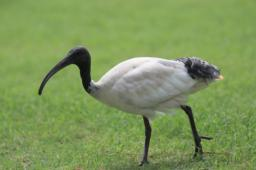

In [5]:
dest = "__files__/q2/example/"
query = "ibis"
imgs = download_images(query, dest, max_images=1, max_image_size=256)
print(f"Viewing: {imgs[0]}")
im = fva.Image.open(imgs[0])
im.to_thumb(256,256)


Now that we can download images, we will create a list of animals to download images for, and some variations of search terms for each animal to aid in the generalisation of the model.

In [6]:
animals = (
  "Ibis",
  "Bush Turkey",
  "Kangaroo",
  "Emu",
  "Crocodile",
  "Koala",
  "Platypus",
  "Echidna",
  "Cockatoo",
  "Wombat"
)

variants = (
  " australian animal in sunlight",
  " australian animal in the shade",
  " australian animal in the bush"
)

root = "__files__/q2"
dest = f"{root}/train"

test_percent = 0.2
test_dest = f"{root}/test"

# Clear Old Data
if os.path.exists(root):
  shutil.rmtree(root)

for animal, variant in itertools.product(animals, variants):
  files = download_images(f"{animal}{variant}", f"{dest}/{animal}/", clear_directory=False, max_images=100, max_image_size=256)
  for file_name in random.sample(files, int(len(files) * test_percent)):
    path = Path(f"{test_dest}/{animal}/")
    path.mkdir(exist_ok=True, parents=True)
    shutil.move(file_name, str(path))
  time.sleep(3)
  

Resizing images...
For Query: 'Ibis australian animal in sunlight', Downloaded a total of 96 images to __files__/q2/train/Ibis/
Resizing images...
For Query: 'Ibis australian animal in the shade', Downloaded a total of 174 images to __files__/q2/train/Ibis/
Resizing images...
For Query: 'Ibis australian animal in the bush', Downloaded a total of 236 images to __files__/q2/train/Ibis/
Resizing images...
For Query: 'Bush Turkey australian animal in sunlight', Downloaded a total of 99 images to __files__/q2/train/Bush Turkey/
Resizing images...
For Query: 'Bush Turkey australian animal in the shade', Downloaded a total of 176 images to __files__/q2/train/Bush Turkey/
Resizing images...
For Query: 'Bush Turkey australian animal in the bush', Downloaded a total of 238 images to __files__/q2/train/Bush Turkey/
Resizing images...
For Query: 'Kangaroo australian animal in sunlight', Downloaded a total of 94 images to __files__/q2/train/Kangaroo/
Resizing images...
For Query: 'Kangaroo australi

# Step 2: Train a classifier
Now we train our multi-class classifier. We will use the fast.ai library to do this.

First we filter out any images that cannot be opened, and then we create a DataBlock object from the images.

In [7]:
for p in [dest, test_dest]:
  failed = fva.verify_images(fva.get_image_files(p))
  failed.map(Path.unlink)
  print(len(failed))

24
15


In [8]:
dls = fva.DataBlock(
    blocks=(fva.ImageBlock, fva.CategoryBlock), 
    get_items=fva.get_image_files, 
    splitter=fva.RandomSplitter(valid_pct=0.2, seed=42),
    get_y=fva.parent_label,
    item_tfms=[fva.Resize(256, method='squish')]
).dataloaders(dest)

dls_test = fva.DataBlock(
    blocks=(fva.ImageBlock, fva.CategoryBlock), 
    get_items=fva.get_image_files, 
    get_y=fva.parent_label,
    item_tfms=[fva.Resize(256, method='squish')]
).dataloaders(test_dest)

With the data successfully loaded, we can now train a model. A sample of the images is shown below.

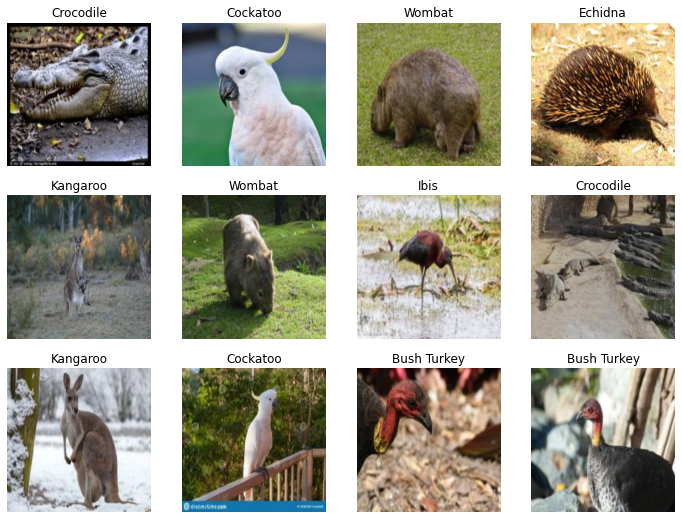

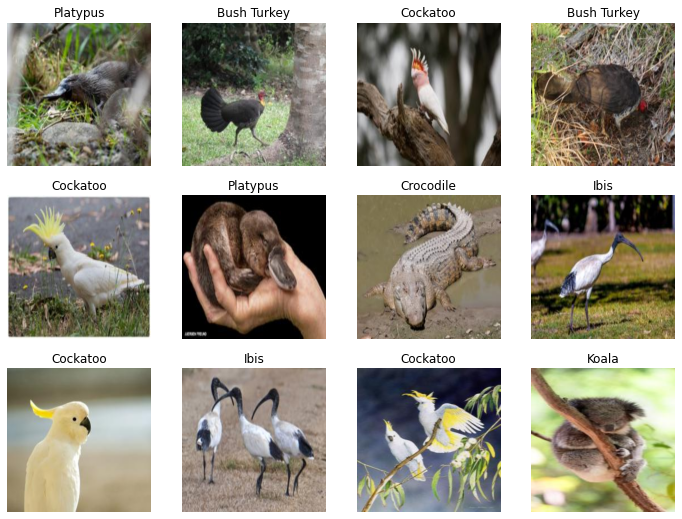

In [9]:
dls.show_batch(max_n=12)
dls_test.show_batch(max_n=12)

With the DataLoaders object, we can now train a model. We will use a ResNet18 model and accuracy as our metric. TODO: Explain why we use accuracy as our metric. and model.
The model chosen for this task is a ResNet18 model. ResNet18 is a convolutional network with 18 deep layers. Initially developed by Kaiming He et al. in 2015, it was the winner of the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2015. The generalised training of the mdoel and the wide availability in machine learning libraries makes it a good choice for transfer learning. The model is shown below.

![resnet18](./images/ResNet-18-architecture-20-The-numbers-added-to-the-end-of-ResNet-represent-the.png)

For the loss function, we will use Cross Entropy Loss. This is a standard loss function for multi-class classification problems. It is defined as follows,
$$
L_{CE} = -\sum_{i=1}^{N} y_i \log(p_i)
$$

Where $L_{CE}$ is the cross entropy loss, $N$ is the number of classes, $y_i$ is the true label of the $i^{th}$ class, and $p_i$ is the predicted probability of the $i^{th}$ class. This function is a suitable metric for this application as it,
* Penalises incorrect predictions more than correct predictions
* Is applicable to multiclass problems

This loss function is implemented in the fast.ai library.

The model metric we will use is accuracy, although quite simple, it is a good metric for this application as it is easy to interpret and understand. It is defined as follows,

$$
accuracy = \frac{\text{correct predictions}}{\text{total predictions}}
$$

This metric is implemented in the fast.ai library.

Finally, the model will be trained using transfer learning, for a total of 3 epochs. Minimal training time and a small dataset make this a suitable choice for this application.

The model is trained below.

In [10]:
learn = fva.cnn_learner(dls, fva.resnet18, pretrained=True, metrics=[fva.accuracy])
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.150297,0.156331,0.954301,00:13
1,0.080739,0.155329,0.959677,00:13
2,0.053283,0.140221,0.962366,00:13
3,0.034219,0.148597,0.962366,00:13
4,0.022707,0.150025,0.962366,00:13


The training and validation loss are shown below.

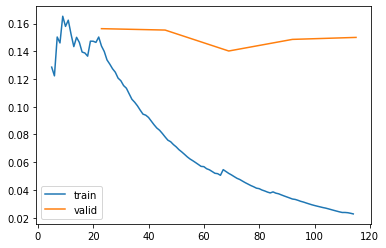

In [11]:
learn.recorder.plot_loss()

# Step 3: Interpret the results

With our trained model, we can now interpret the results. We will use a confusion matrix and t-SNE to visualise the results of our model. We will also be evaluating the model over a previously unseen test set. First we will evaluate the models' performance with a sample prediction and by inspecting the top losses.

We can also note the final training accuracy of the model on the validation set of 0.975. This is contrasted to the test accuracy of 0.789, a noticeable drop. This suggests that the model is overfitting to the training data. This is not surprising given the small size of the dataset and the minimal training time. 

[('Koala', 'Cockatoo', 27), ('Emu', 'Kangaroo', 18), ('Koala', 'Kangaroo', 12), ('Ibis', 'Cockatoo', 10), ('Emu', 'Cockatoo', 9), ('Wombat', 'Kangaroo', 9), ('Bush Turkey', 'Kangaroo', 8), ('Platypus', 'Cockatoo', 8), ('Ibis', 'Kangaroo', 5), ('Bush Turkey', 'Ibis', 4), ('Echidna', 'Cockatoo', 4), ('Echidna', 'Crocodile', 4), ('Kangaroo', 'Cockatoo', 4), ('Bush Turkey', 'Cockatoo', 3), ('Bush Turkey', 'Crocodile', 3), ('Crocodile', 'Cockatoo', 3), ('Echidna', 'Platypus', 3), ('Ibis', 'Platypus', 3), ('Platypus', 'Crocodile', 3), ('Platypus', 'Kangaroo', 3), ('Wombat', 'Cockatoo', 3), ('Emu', 'Crocodile', 2), ('Emu', 'Platypus', 2), ('Ibis', 'Bush Turkey', 2), ('Koala', 'Crocodile', 2)]
0.789340078830719


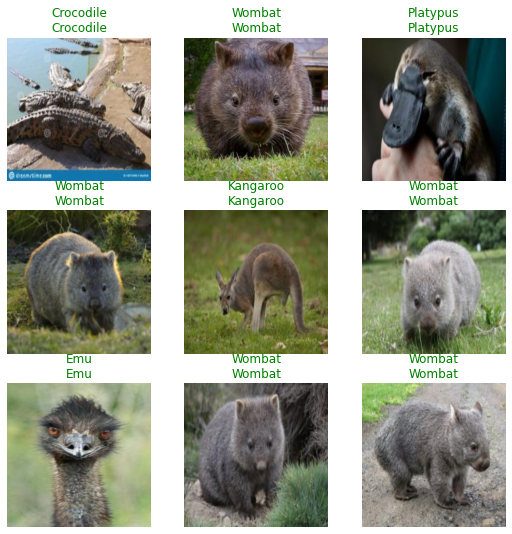

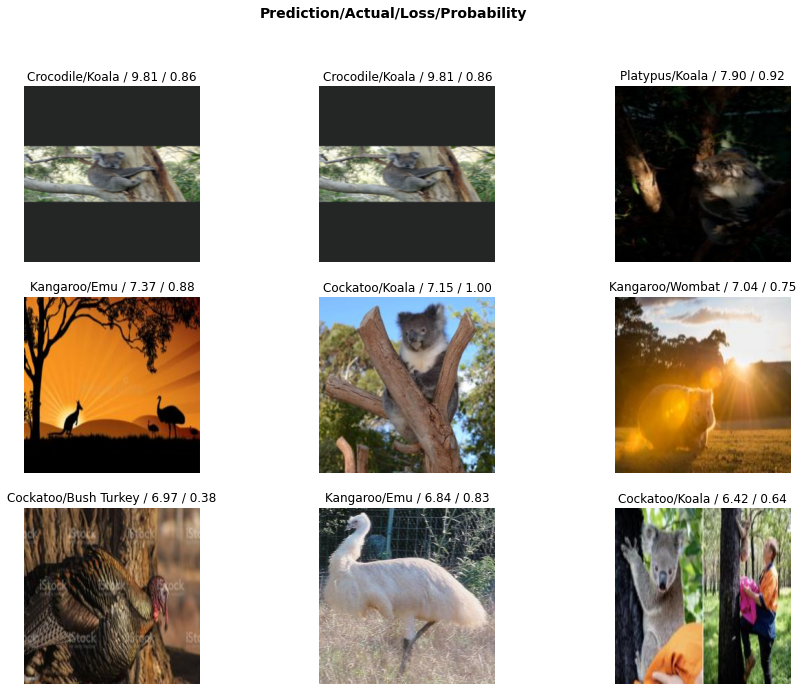

In [19]:
dls.valid = dls_test.train
learn.show_results()
interp = fva.ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))
print(interp.most_confused(min_val=2))
metrics=learn.recorder.metrics
print(metrics[0].value.item()) # float

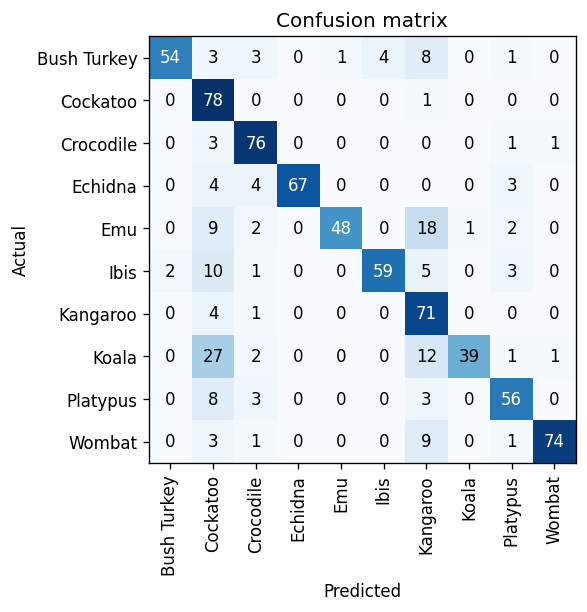

In [13]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=120)

The purpose of a confusion matrix is to outline the classification spread for each entry. This involves analsysis of true positives vs. false positives, and true negatives vs. false negatives. In addition, it allows for accuracy to be calculated for each class and investigation into sensitivity and specificity.

The confusion matrix shown above summarises the performance quite well, performing generally well across all classes. An exception is the koala class which has a heavy confusion with cockatoos. This is understandable as both animals are generally grey and generally reside in trees. The confusion matrix also shows a general tendency to misclassify emus as kangaroos. This is much more understandable when considering the misclassification shown in the peak loss plot. The generated image of an emu is that of a brownish mass residing on the ground, similar to that of a kangaroo. This is a good example of how the model is not perfect, and how the model can be improved by providing more training data to ensure that the model can generalise to a wider range of images.

Also interstingly, from the top loss plot, we can observe that some clip-art has been included in the test set and presumably training data. This also likely impacted the generalisation of the model as the only correlation between this and a photo of an actual animal would be general shape. It is also worth noting, that this photo contains not only an emu, but also a kangaroo, somewhat explaining the misclassification in this case. As the training data is collected from DDGS, it is not surprising that a wide variety of style types and some overlap between animals is included.

In [14]:
# Note, based upon the FastAI example provided here: https://github.com/suredie/FastAI-Examples/blob/master/HelloWorld/Save_Features.ipynb
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

sf = SaveFeatures(learn.model[1][1])
pred_vector, label = learn.get_preds(ds_idx=1)
label = label.numpy()
pred_label = np.argmax(pred_vector.numpy(), axis=1)
extracted_features = sf.features

/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:xlabel='TSNE - Primary Component 1 []', ylabel='TSNE - Primary Component 2 []'>

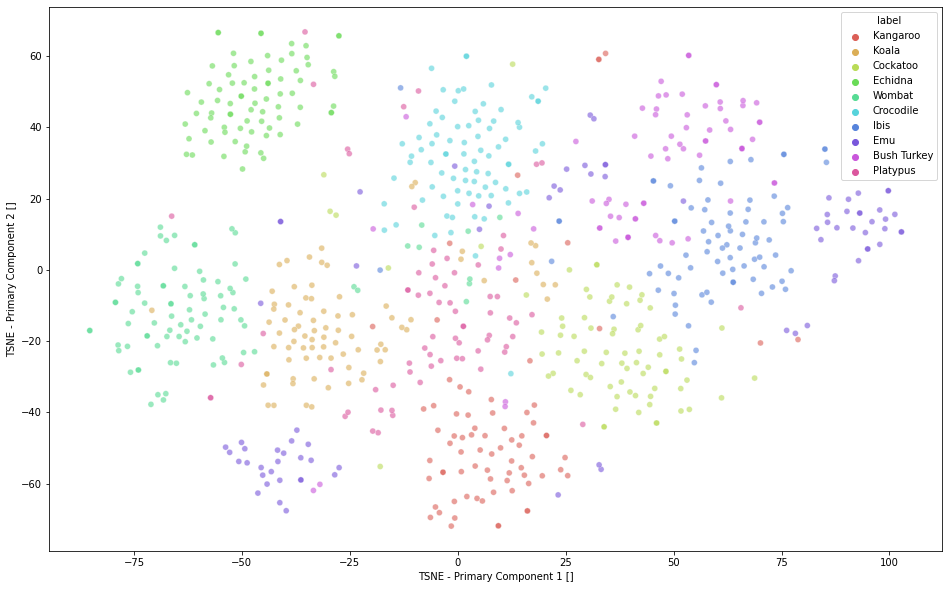

In [15]:
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_features = tsne.fit_transform(extracted_features)
data = {}
data["TSNE - Primary Component 1 []"] = tsne_features[:,0]
data["TSNE - Primary Component 2 []"] = tsne_features[:,1]
data["label"] = [dls.valid.vocab[x] for x in label]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="TSNE - Primary Component 1 []", y="TSNE - Primary Component 2 []",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.6
)

T-Distributed Stochastic Neighbour Embedding (TSNE) is a method for visualising high dimensional data. It functions by mapping each datapoint to a location in a two or three dimensional map to show correlations between datapoints based on their distance from each other. This is useful for visualising the results of a classification model as it allows us to see how the model has clustered the data.

It also allows for analsysis of the model performance. For example, if the model is performing well, we would expect to see distinct clusters of points, with minimal overlap. If the model is performing poorly, we would expect to see a large amount of overlap between points, suggesting that the model is not able to distinguish between classes.

From the TSNE plot, we can interpret the classification results as clusters from primary components. In general we see noticeable clumps of points, suggesting that the model is performing well. However, we can also see a noticeable overlap and melding in the centre, correlating with the reduced accuracy of the model. Most notable, is the distribution of the emu class, which is spread across the entire plot. This is likely due to the misclassification of emus as kangaroos, as discussed above.